# Machine Learning Homework 3

Fine-Tuning Stable Diffusion for Style Transfer using LoRA

In [2]:
import os
import logging
import torch
import numpy as np
from diffusers import StableDiffusionPipeline, DiffusionPipeline,  DPMSolverMultistepScheduler, DDPMScheduler, AutoencoderKL, UNet2DConditionModel
from PIL import Image
import matplotlib.pyplot as plt
from dotenv import dotenv_values
from diffusers.utils import check_min_version, convert_state_dict_to_diffusers, is_wandb_available
from accelerate.logging import get_logger
from pathlib import Path
from accelerate.utils import ProjectConfiguration, set_seed
from accelerate import Accelerator
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig
from diffusers.training_utils import cast_training_params, compute_snr
from datasets import load_dataset, load_from_disk
import random
from torchvision import transforms
from diffusers.utils.torch_utils import is_compiled_module
from diffusers.optimization import get_scheduler
import math
from tqdm import tqdm
import torch.nn.functional as F
from peft.utils import get_peft_model_state_dict
from io import BytesIO

## initialisation

In [3]:
class Args:
    model_base : str = "stabilityai/stable-diffusion-2-1"
    use_wandb : bool = True
    seed : int = 1623
    output_dir : str = "outputs"
    logging_dir : str = "logs"
    resolution : int = 512
    crop : bool = False
    # validation
    validation_n_samples : int = 3
    validation_prompt : str = "batman as a sherif in a vintage style"
    validation_epochs : int = 2
    # training
    gradient_accumulation_steps : int = 2
    learning_rate : float = 1e-5
    train_batch_size : int = 6
    train_data_dir : str = "inputs"
    train_data_subpath : str = "vintage"
    max_train_steps : int = 1000
    resume_training : bool = True
    checkpointing_steps : int = 400
    max_grad_norm : float = 1.0
    # lora
    lora_rank : int = 80
    snr_gamma : float = 5.0   
    
    
args = Args()

os.makedirs(args.output_dir, exist_ok=True)

!nvidia-smi

if args.use_wandb and is_wandb_available():
    wanb_api_key = dotenv_values(".env")["WANDB_API_KEY"]
    !wandb login $wanb_api_key
    import wandb

check_min_version("0.32.0.dev0")

logger = get_logger(__name__, log_level="INFO")

logging_dir = Path(args.output_dir, args.logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)
report_to = "tensorboard" if not args.use_wandb else "wandb"
accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision="fp16",
    log_with=report_to,
    project_config=accelerator_project_config,
)

# Disable AMP for MPS
if torch.backends.mps.is_available():
    accelerator.native_amp = False
    
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO
)

logger.info(accelerator.state, main_process_only=False)

set_seed(args.seed)

Sat Jan  4 09:59:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8             12W /  220W |       7MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
01/04/2025 09:59:54 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



## Utils

In [4]:
def load_pipeline(model_base, model_path, device):
    pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    if model_path is not None:
        pipe.unet.load_attn_procs(model_path)
    pipe.to(device)
    return pipe


def generate_images(pipe, num_images, prompt, generator, scale=9, disable_safety=False):
    imgs = []
    
    if disable_safety:
        def null_safety(images, **kwargs):
            return images, False
        pipe.safety_checker = null_safety
    
    with torch.autocast("cuda"):
        imgs = pipe(num_images*[prompt], guidance_scale=scale, generator=generator).images
    return imgs


def image_grid(imgs, rows, cols, resize=256, spacing=1):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w + (cols - 1) * spacing, rows * h + (rows - 1) * spacing
    grid = Image.new("RGB", size=(grid_w, grid_h), color=(255, 255, 255, 50))

    for i, img in enumerate(imgs):
        x = i % cols * (w + spacing)
        y = i // cols * (h + spacing)
        grid.paste(img, box=(x, y))

    return grid


def log_validation(pipe, args, accelerator, epoch, final_validation=False):
    logger.info(f"Validation epoch {epoch}... \n Generating {args.validation_n_samples} images with prompt: {args.validation_prompt}")
    
    pipe = pipe.to(accelerator.device)
    pipe.set_progress_bar_config(disable=True)
    generator = torch.Generator().manual_seed(args.seed)
    imgs = generate_images(pipe, args.validation_n_samples, args.validation_prompt, generator)
    
    for tracker in accelerator.trackers:
        phase_name = "test" if final_validation else "validation"
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in imgs])
            tracker.writer.add_images(phase_name, np_images, epoch, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    phase_name: [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(imgs)
                    ]
                }
            )
    return imgs


def setup_pipe_models(model_base, lora_rank, accelerator):
    noise_scheduler = DDPMScheduler.from_pretrained(model_base, subfolder="scheduler")
    tokenizer = CLIPTokenizer.from_pretrained(model_base, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_base, subfolder="text_encoder")
    vae = AutoencoderKL.from_pretrained(model_base, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(model_base, subfolder="unet")
    
    # freeze parameters of models
    for m in [unet, text_encoder, vae]:
        for param in m.parameters():
            param.requires_grad = False
    
    unet_lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"]
    )
    
    # cast non-trainable parameters to half precision
    weight_dtype = torch.float16
    unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)
    
    unet.add_adapter(unet_lora_config)
    cast_training_params(unet, dtype=torch.float32)

    return noise_scheduler, tokenizer, text_encoder, vae, unet
    
    
def unwrap_model(model, accelerator):
    model = accelerator.unwrap_model(model)
    model = model._orig_mod if is_compiled_module(model) else model
    return model    

## Dataset Management

In [5]:
dataset = load_dataset(
    "parquet", data_dir=f"./{args.train_data_dir}/{args.train_data_subpath}"
)

[image_column, caption_column] = dataset['train'].column_names

train_transforms = transforms.Compose(
    [
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution) if args.crop else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

tokenizer = CLIPTokenizer.from_pretrained(args.model_base, subfolder="tokenizer")

def tokenize_captions(examples, is_train=True):
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids
    
def preprocess_train(examples):
    images = [Image.open(BytesIO(image_dict['bytes'])).convert("RGB").resize((args.resolution, args.resolution), Image.Resampling.LANCZOS) for image_dict in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).to(dtype=torch.float16)
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}


train_dataset = dataset["train"].with_transform(preprocess_train)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size
)

## Fine-tuning Process

In [5]:
noise_scheduler, tokenizer, text_encoder, vae, unet = setup_pipe_models(args.model_base, args.lora_rank, accelerator)
args.learning_rate = args.learning_rate * args.gradient_accumulation_steps * accelerator.num_processes * args.train_batch_size
lora_layers = filter(lambda p: p.requires_grad, unet.parameters())

optimizer = torch.optim.AdamW(
    lora_layers,
    lr=args.learning_rate
)

lr_scheduler = get_scheduler(
    "cosine",
    optimizer,num_warmup_steps=500*accelerator.num_processes,
    num_training_steps=args.max_train_steps*accelerator.num_processes,
)

unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

if accelerator.is_main_process:
    accelerator.init_trackers("stable_diffusion-fine-tuning", config=vars(args))

total_batch_size = args.train_batch_size * args.gradient_accumulation_steps * accelerator.num_processes
logger.info("***** Running Stable Diffusion fine-tune training *****")
logger.info(f"  Dataset size = {len(train_dataset)}")
logger.info(f"  Num Epochs = {epochs}")
logger.info(f"  Train Batch size = {args.train_batch_size}")
logger.info(f"  Total train batch size  = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
logger.info(f"  Using WANDB: {args.use_wandb}")
logger.info(f"  Seed = {args.seed}")
global_step = 0
first_epoch = 0

if args.resume_training:
    dirs = os.listdir(args.output_dir)
    dirs = [d for d in dirs if d.startswith("checkpoint")]
    dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
    path = dirs[-1] if len(dirs) > 0 else None
    
    if path is None:
        accelerator.print("No checkpoint found, starting from scratch")
        initial_global_step = 0
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(args.output_dir, path))
        global_step = int(path.split("-")[1])

        initial_global_step = global_step
        first_epoch = global_step // num_update_steps_per_epoch
else:
    initial_global_step = 0

progress_bar = tqdm(range(0, args.max_train_steps), desc="Steps", disable=not accelerator.is_main_process)
for epoch in range(first_epoch, epochs):
    unet.train()
    train_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            # pixels to latent space
            latents = vae.encode(batch["pixel_values"].to(accelerator.device)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            
            # Sample noise
            noise = torch.randn_like(latents)
            
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config['num_train_timesteps'], (latents.shape[0],), device=latents.device)
            timesteps = timesteps.long()
            
            # foward diffusion
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            encoder_hidden_states = text_encoder(batch["input_ids"], return_dict=False)[0] # embeddings
            
            if noise_scheduler.config['prediction_type'] == "epsilon":
                    target = noise
            elif noise_scheduler.config['prediction_type']  == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
            
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
            
            snr = compute_snr(noise_scheduler, timesteps)
            mse_loss_weights = torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0]
            if noise_scheduler.config['prediction_type']  == "epsilon":
                mse_loss_weights = mse_loss_weights / snr
            elif noise_scheduler.config['prediction_type']  == "v_prediction":
                mse_loss_weights = mse_loss_weights / (snr + 1)
                
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
            loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
            loss = loss.mean()
            
            avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
            train_loss += avg_loss.item() / args.gradient_accumulation_steps
            
            # Backpropagation
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = lora_layers
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            accelerator.log({"train_loss": train_loss}, step=global_step)
            train_loss = 0.0
            
            if global_step % args.checkpointing_steps == 0:
                if accelerator.is_main_process:
                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)

                    unwrapped_unet = unwrap_model(unet, accelerator)
                    unet_lora_state_dict = convert_state_dict_to_diffusers(
                        get_peft_model_state_dict(unwrapped_unet)
                    )
                    StableDiffusionPipeline.save_lora_weights(
                        save_directory=save_path,
                        unet_lora_layers=unet_lora_state_dict,
                        safe_serialization=True,
                    )
                    logger.info(f"Saved state to {save_path}")
                        
        logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)

        if global_step >= args.max_train_steps:
            break
        
    if accelerator.is_main_process:
        if epoch % args.validation_epochs == 0:
            pipeline = DiffusionPipeline.from_pretrained(
                args.model_base,
                unet=unwrap_model(unet, accelerator),
                torch_dtype=torch.float16,
            )
            images = log_validation(pipeline, args, accelerator, epoch)

            del pipeline
            torch.cuda.empty_cache()

accelerator.wait_for_everyone()
if accelerator.is_main_process:
    unet = unet.to(torch.float32)
    
    unwrapped_unet = unwrap_model(unet, accelerator)
    unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unwrapped_unet))
    StableDiffusionPipeline.save_lora_weights(
        save_directory=f"{args.output_dir}/{args.train_data_subpath}",
        unet_lora_layers=unet_lora_state_dict,
        safe_serialization=True,
    )
    
    # Test
    pipeline = load_pipeline(args.model_base, f"{args.output_dir}/{args.train_data_subpath}", accelerator.device)
    images = log_validation(pipeline, args, accelerator, epoch, final_validation=True)
    del pipeline
    
accelerator.end_training()

try:
    del tokenizer, text_encoder, vae, unet, optimizer, lr_scheduler, train_dataloader, train_dataset, pipeline
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    pass

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dkgmgo (dkgmgo-ml). Use `wandb login --relogin` to force relogin


01/04/2025 08:52:00 - INFO - __main__ - ***** Running Stable Diffusion fine-tune training *****
01/04/2025 08:52:00 - INFO - __main__ -   Dataset size = 685
01/04/2025 08:52:00 - INFO - __main__ -   Num Epochs = 18
01/04/2025 08:52:00 - INFO - __main__ -   Train Batch size = 6
01/04/2025 08:52:00 - INFO - __main__ -   Total train batch size  = 12
01/04/2025 08:52:00 - INFO - __main__ -   Gradient Accumulation steps = 2
01/04/2025 08:52:00 - INFO - __main__ -   Total optimization steps = 1000
01/04/2025 08:52:00 - INFO - __main__ -   Using WANDB: True
01/04/2025 08:52:00 - INFO - __main__ -   Seed = 1623


No checkpoint found, starting from scratch


Steps:   6%|▌         | 58/1000 [00:59<12:35,  1.25it/s, lr=1.39e-5, step_loss=0.174] Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6eb65e7b10>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: c3409405-f4b6-4c78-9a47-e871953aa3a1)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 08:55:09 - INFO - __main__ - Validation epoch 0... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps:  17%|█▋        | 174/1000 [05:26<10:42,  1.29it/s, lr=4.18e-5, step_loss=0.117]   Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6ed040fe10>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: bfbbf6b6-6e0d-4dea-be9d-997b7fd57b2c)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 08:59:38 - INFO - __main__ - Validation epoch 2... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps:  29%|██▉       | 290/1000 [09:54<09:14,  1.28it/s, lr=6.96e-5, step_loss=0.0748]   Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6ed04c7a50>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: b0742f60-ab1d-45e6-b1dd-3c48678a732e)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 09:04:06 - INFO - __main__ - Validation epoch 4... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps:  40%|████      | 400/1000 [14:17<10:39,  1.07s/it, lr=9.58e-5, step_loss=0.162]   01/04/2025 09:06:18 - INFO - accelerate.accelerator - Saving current state to outputs/checkpoint-400
01/04/2025 09:06:20 - INFO - accelerate.checkpointing - Model weights saved in outputs/checkpoint-400/model.safetensors
01/04/2025 09:06:20 - INFO - accelerate.checkpointing - Optimizer state saved in outputs/checkpoint-400/optimizer.bin
01/04/2025 09:06:20 - INFO - accelerate.checkpointing - Scheduler state saved in outputs/checkpoint-400/scheduler.bin
01/04/2025 09:06:20 - INFO - accelerate.checkpointing - Sampler state for dataloader 0 saved in outputs/checkpoint-400/sampler.bin
01/04/2025 09:06:20 - INFO - accelerate.checkpointing - Gradient scaler state saved in outputs/checkpoint-400/scaler.pt
01/04/2025 09:06:20 - INFO - accelerate.checkpointing - Random state

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 09:08:36 - INFO - __main__ - Validation epoch 6... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps:  52%|█████▏    | 522/1000 [18:53<06:13,  1.28it/s, lr=0.000119, step_loss=0.00377]Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6ea45bc110>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: aa0a1a89-fc0e-4e1c-bc79-ecad7c0c2780)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 09:13:05 - INFO - __main__ - Validation epoch 8... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps:  64%|██████▍   | 638/1000 [23:21<04:42,  1.28it/s, lr=9.88e-5, step_loss=0.13]     Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6eb76f66d0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 61b84595-4029-47dc-8077-4f395742ba93)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 09:17:33 - INFO - __main__ - Validation epoch 10... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps:  75%|███████▌  | 754/1000 [27:50<03:12,  1.28it/s, lr=5.85e-5, step_loss=0.194]   Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6ed2516910>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: e7d3e7f0-2334-4ced-838d-b2ad4a90b143)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 09:22:01 - INFO - __main__ - Validation epoch 12... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps:  80%|████████  | 800/1000 [31:06<03:30,  1.05s/it, lr=4.18e-5, step_loss=0.123]   01/04/2025 09:23:06 - INFO - accelerate.accelerator - Saving current state to outputs/checkpoint-800
01/04/2025 09:23:08 - INFO - accelerate.checkpointing - Model weights saved in outputs/checkpoint-800/model.safetensors
01/04/2025 09:23:08 - INFO - accelerate.checkpointing - Optimizer state saved in outputs/checkpoint-800/optimizer.bin
01/04/2025 09:23:08 - INFO - accelerate.checkpointing - Scheduler state saved in outputs/checkpoint-800/scheduler.bin
01/04/2025 09:23:08 - INFO - accelerate.checkpointing - Sampler state for dataloader 0 saved in outputs/checkpoint-800/sampler.bin
01/04/2025 09:23:08 - INFO - accelerate.checkpointing - Gradient scaler state saved in outputs/checkpoint-800/scaler.pt
01/04/2025 09:23:08 - INFO - accelerate.checkpointing - Random stat

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 09:26:32 - INFO - __main__ - Validation epoch 14... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps:  99%|█████████▊| 986/1000 [36:48<00:10,  1.28it/s, lr=2.32e-7, step_loss=0.0653]  Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6ea4574110>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: f464241f-dec4-4800-9557-bff891c1c4f7)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

01/04/2025 09:31:00 - INFO - __main__ - Validation epoch 16... 
 Generating 3 images with prompt: batman as a sherif in a vintage style
Steps: 100%|██████████| 1000/1000 [39:31<00:00,  1.47s/it, lr=0, step_loss=0.148]       Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6ed0564750>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 4cac1605-0fbe-41d9-9dae-a7236678665b)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/gausse/anaconda3/envs/lora/lib/python3.11/site-packages/diffusers/loaders/unet.py:215: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)
01/04/2025 09:33:43 - INFO - __main__ - Validation epoch 17... 
 Generating 3 images with prompt: batman as a sherif in a vintage style


train_loss,▄▄▅▆█▅▄▅▅▃▅▆▃▅▂▃▅▃▇▄▅▅▃▆▆▄▂▇▂▃▅▇▇█▃▂▅▃▃▁
train_loss,0.11903


## Generate some style images  

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fec88f7bd10>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 5e76e47e-e2e1-45af-862d-080418052a6e)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fec89177650>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 8b97de7f-2fe6-4a67-ae5a-c1e7b18c2f09)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fec8845dfd0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: b99f4ea8-9b97-4279-b567-bd8f006c6e90)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

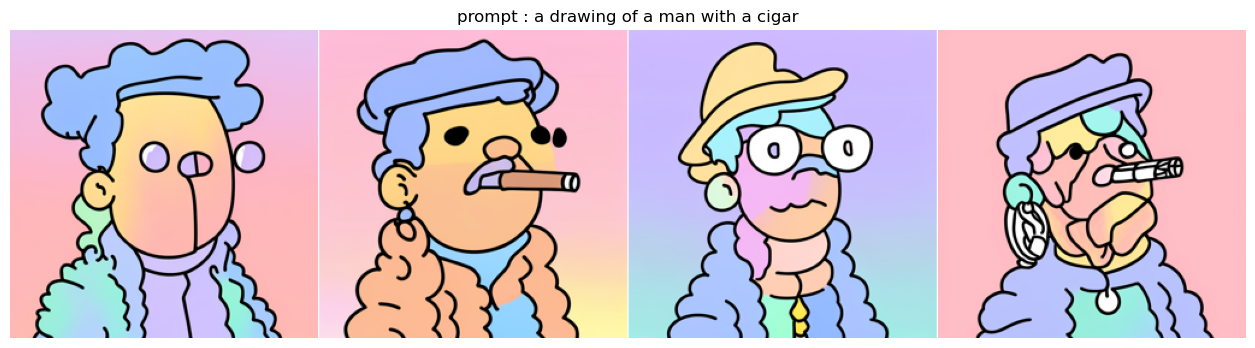

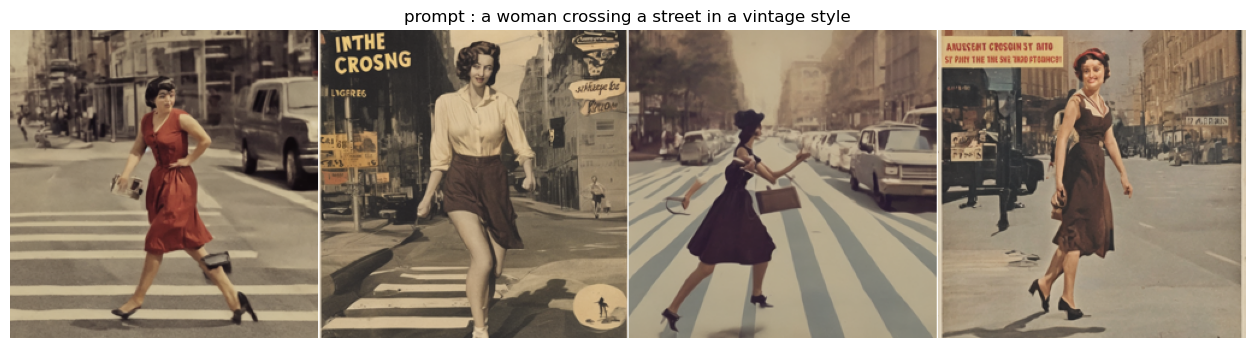

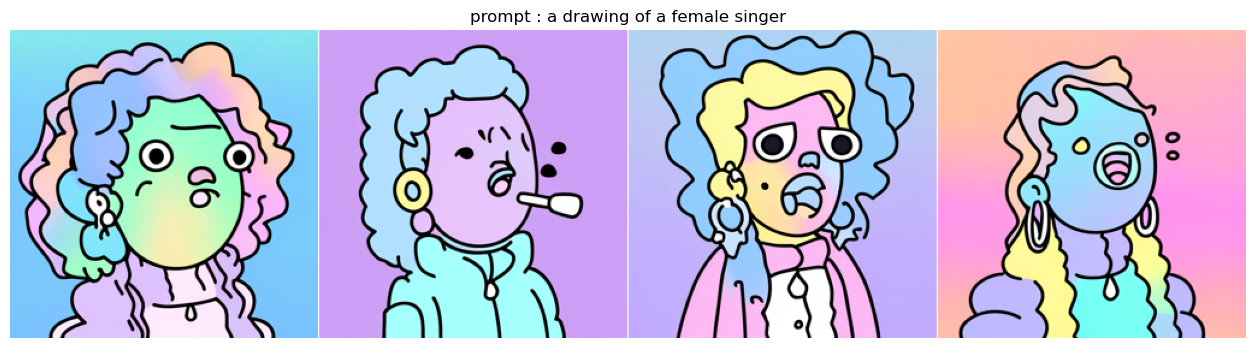

In [11]:
# check precision
def plot_lora_results(subpath, prompt, seed):
    pipeline = load_pipeline(args.model_base, f"{args.output_dir}/{subpath}", accelerator.device)
    generator = torch.Generator().manual_seed(seed)
    images = generate_images(pipeline, 4, prompt, generator)
    grid = image_grid(images, 1, 4, resize=256)
    plt.figure(figsize=(16, 4))
    plt.axis("off")
    plt.title(f"prompt : {prompt}")
    plt.imshow(grid)
    
    try:
        del pipeline, images, grid
        import gc; gc.collect()
    except:
        pass

plot_lora_results("doodles", "a drawing of a man with a cigar", 1234)
plot_lora_results("vintage", "a woman crossing a street in a vintage style", 1234)
plot_lora_results("doodles", "a drawing of a female singer", 160)

## Testing and comparing generation effects

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fecc5732e50>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 73e8f856-979b-4345-9cc5-aa75bb84c231)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fecc582fd10>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: d1ffdec7-f9be-4b9c-8871-99a797f4402c)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

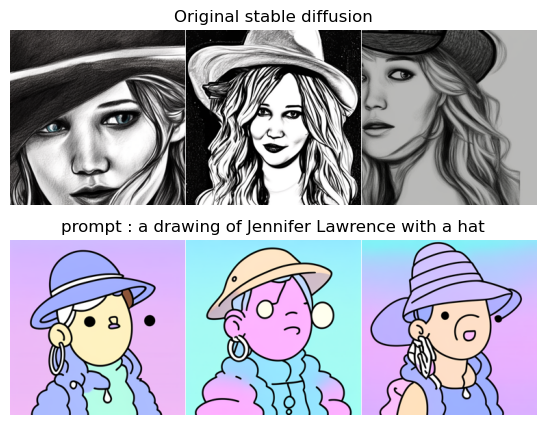

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fec890251d0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: adf5836b-f545-4b22-a121-b48adc6fd5e2)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fec881d8510>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: b359e173-7f3b-4d0d-9fc1-761b6b7faeae)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

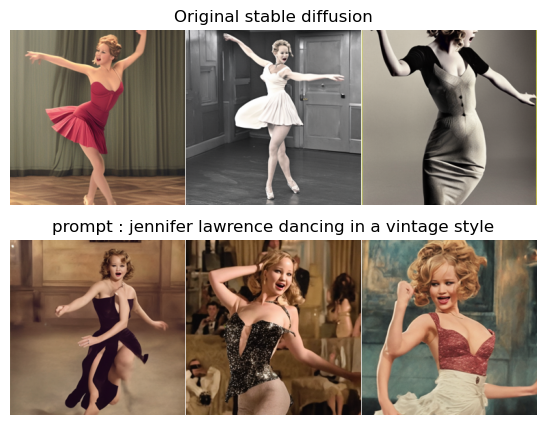

In [10]:
def compare_a_lora_results(subpath, prompt, seed):
    original_pipe = load_pipeline(args.model_base, None, accelerator.device)
    lora_pipe = load_pipeline(args.model_base, f"{args.output_dir}/{subpath}", accelerator.device)
    generator = torch.Generator().manual_seed(seed)
    original_images = generate_images(original_pipe, 3, prompt, generator)
    lora_images = generate_images(lora_pipe, 3, prompt, generator)

    original_grid = image_grid(original_images, 1, 3, resize=256)
    lora_grid = image_grid(lora_images, 1, 3, resize=256)
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    ax[0].imshow(original_grid)
    ax[0].set_title("Original stable diffusion")
    ax[0].axis("off")
    ax[1].imshow(lora_grid)
    ax[1].set_title(f"Fine-tuned with {subpath} dataset")
    ax[1].axis("off")
    plt.title(f"prompt : {prompt}")
    plt.show()
    try:
        del original_pipe, lora_pipe, original_images, lora_images, original_grid, lora_grid
        import gc; gc.collect()
    except:
        pass
    
compare_a_lora_results("doodles", "a drawing of Jennifer Lawrence with a hat", 42)
compare_a_lora_results("vintage", "jennifer lawrence dancing in a vintage style", 5)
